# Machine learning as a valuable tool to assist in large-scale, activity-based SCRA screening of plasma samples 

This notebook serves as the main document of the machine-learning-based classification of SCRA receptor-activation profiles. While our data is not publicly available, this notebook can almost readily be applied to a specific user-defined dataset of profiles.

0. Libraries: necessary software packages are loaded (made available to work with)
1. Data processing: (a) data are loaded from .xlsx sheets and processed per experiment (median of blanks is subtracted); (b) data are transformed into feature representations (5th order polynomial fit, tsfresh)
2. Machine learning models: a Random Forest classifier is built via two 10-fold cross-validation schemes and based on either analytical outcome or expert scoring (details in paper)
3. Evaluating performance: model performance is evaluated via ROC curves and Sensitivity/Specificity plots 
4. Venn diagram: computed to visualize the accordance between analytical outcome, expert scoring and machine learning predictions
5. AUC confidence intervals: 95% confidence intervals are computed via bootstrapping

## 0 - Libraries

In [12]:
import random 
import numpy as np
import pandas as pd
import helpers as hl
import seaborn as sns
from tqdm import tqdm
from scipy.fft import fft
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy import signal, integrate
from sklearn.externals import joblib
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
from tsfresh import extract_features, select_features
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, minmax_scale
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold, GroupKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import roc_curve, auc, make_scorer, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

## 1 - Data preprocessing

First, we load the Excel sheets as dataframes, transform them to matrices and transpose to get an appropriate format. We select the first 58 columns to ensure that NaN values are excluded (in this dataset!).

We work with the corrected profiles, in the sheet 'n=1 (corrected)'. We also use the blanks as extra information, we compute their median per experiment and subtract that median from the samples. At the end of the first code block, we get a dataframe of profiles with the median of the blanks subtracted, a dataframe of nonsubtracted profiles and the blancks separately.

! IMPORTANT: make sure all .xlsx files and sheetnames are consistently named.

##### Process raw data

In [41]:
# initialize variables and lists for data
n_exp = 23
n_samples = 96
data_list = []
data_subtr_list = []
blanks_list = []
batch = []

# run over all experiments and collect data
for experiment in range(1,n_exp+1):
    sheetname = 'n='+str(experiment)+' (corr)'
    file = '/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/data/2020_CB1_n'+str(experiment)+'.xlsx'
    
    # get the data (4th Excel row = header, so 3rd in DF; first column is timestamp)
    data_xls = pd.ExcelFile(file)
    data = np.matrix(data_xls.parse(sheetname, header=3)).T[1:n_samples+1,0:58]
    
    # get blanks and substract
    blanks = np.concatenate((data[34,:], data[35,:], data[46,:], data[47,:], data[58,:], data[59,:], data[70,:],
                             data[71,:]), axis=0)
    blanks_median = np.median(blanks, axis=0)
    data = np.delete(data, obj=[34, 35, 46, 47, 58, 59, 70, 71], axis=0)
    data = np.asarray(data)
    data_subtr = np.asarray(data - blanks_median)
    
    # add to lists to concatenate later
    data_list.append(data)
    data_subtr_list.append(data_subtr)
    blanks_list.append(np.repeat(blanks_median, data.shape[0], axis=0))
    batch = batch + [experiment]*data.shape[0]
    #print(len(batch))

# concatenate lists
raw_data = np.concatenate(data_list)
raw_data_subtr = np.concatenate(data_subtr_list)
blanks_array = np.concatenate(blanks_list)
   
# collect labels and weights
"""
labels: expert scores
labels_analytic: analytical outcome
labels_test for Venn diagram.
labels_meaning to delete pos+ controls.
"""
labels = np.asarray(pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/data/labels_train.csv', delimiter=";")).reshape(n_exp*88, order='F')
labels_test = np.asarray(pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/data/labels_test_new.csv', delimiter=";")).reshape(n_exp*88, order='F')
labels_analytic = np.asarray(pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/data/labels_analytic_csv.csv', delimiter=";")).reshape(n_exp*88, order='F')
labels_meaning = np.asarray(pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/data/labels_meaning.csv', delimiter=";")).reshape(n_exp*88, order='F')
weights = np.asarray(pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/data/weights_simple.csv', delimiter=";")).reshape(n_exp*88, order='F')

# print checks
print(raw_data.shape, raw_data_subtr.shape, blanks_array.shape, labels.shape, labels_analytic.shape, weights.shape)

(2024, 58) (2024, 58) (2024, 58) (2024,) (2024,) (2024,)


Text(0, 0.5, 'Luminescence')

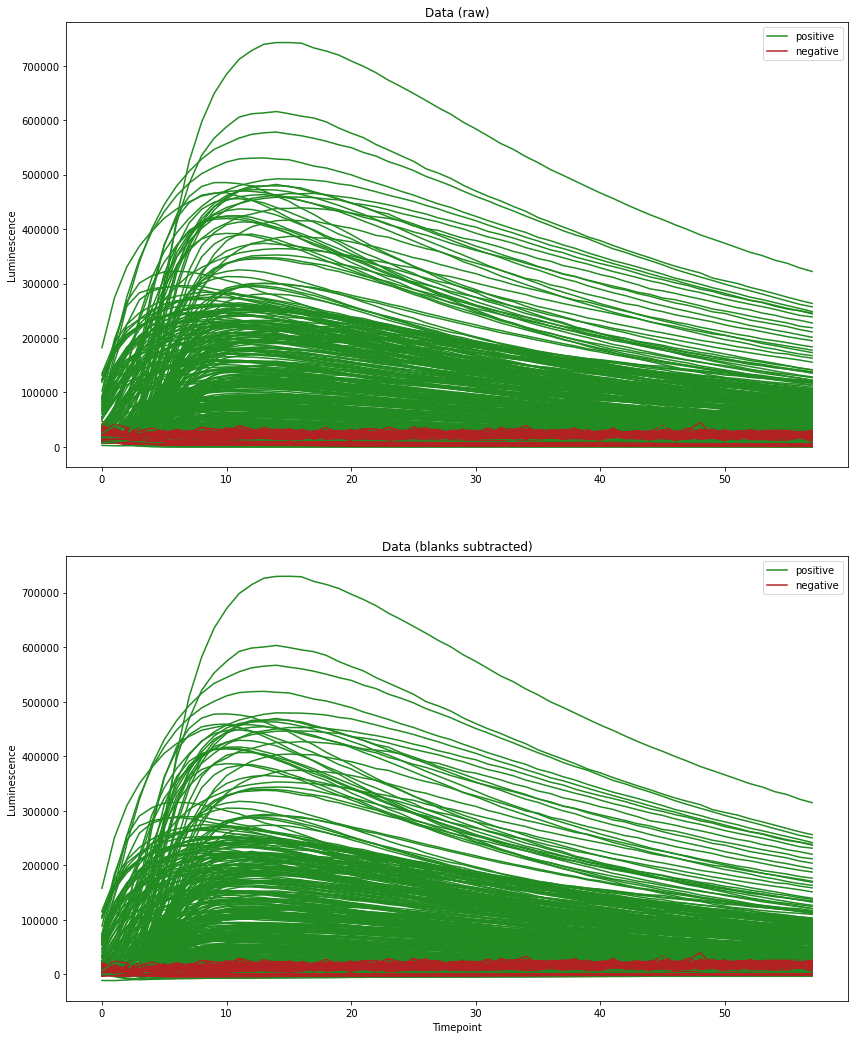

In [5]:
# plot data
fig1, (ax1, ax2) = plt.subplots(figsize=(14,18), nrows=2, ncols=1)
ax1.set_title('Data (raw)')
ax2.set_title('Data (blanks subtracted)')

for i in range(raw_data.shape[0]):
    if labels[i] == 1:
        ax1.plot(raw_data[i,:], color='forestgreen')
        ax2.plot(raw_data_subtr[i,:], color='forestgreen')

    else:
        ax1.plot(raw_data[i,:], color='firebrick')
        ax2.plot(raw_data_subtr[i,:], color='firebrick')
    
# show legends
ax1.plot([], [], color='forestgreen', label='positive'); ax1.plot([], [], color='firebrick', label='negative')
ax2.plot([], [], color='forestgreen', label='positive'); ax2.plot([], [], color='firebrick', label='negative')
ax1.legend(); ax2.legend()
ax2.set_xlabel('Timepoint')
ax1.set_ylabel('Luminescence'); ax2.set_ylabel('Luminescence')

##### Transform data

After collecting and processing the data, we can transform the data into an informative representation ('features') from which machine learning models can learn patterns. To this end we compute the coefficients of a fitted 5th order polynomial to each spectrum and automatically compute a large number of time series characteristics using the *tsfresh* package.

In [3]:
def poly_fit(spectra, degree=5):
    """
    Fit a polynomial of degree 5 to each of the spectra (one row of the dataframe at a time), 
    return the coefs.
    """
    poly_coefs = np.zeros((spectra.shape[0], degree+1))
    x = np.linspace(1, spectra.shape[1], spectra.shape[1])
    for i in range(spectra.shape[0]):
        poly_coefs[i,:] = np.polynomial.polynomial.polyfit(x, spectra[i,:], degree)
    poly_coefs = np.asarray(poly_coefs, dtype=np.float64)
    return poly_coefs

In [4]:
spectra_raw = np.asarray(raw_data_subtr, dtype=np.float64)

# TSFRESH features
tsf_df = pd.DataFrame()
for row in range(spectra_raw.shape[0]):
    df_mini = pd.DataFrame({'values': spectra_raw[row,:], 'id':[row]*spectra_raw.shape[1], 'time':list(range(58))})
    tsf_df = pd.concat([tsf_df, df_mini], axis=0)
tsf_feats = extract_features(tsf_df, column_id='id', column_sort='time')
tsf_feats = tsf_feats.replace([np.inf, -np.inf], np.nan) # convert inf to nan
tsf_colindices = [j for j in range(tsf_feats.shape[1]) if sum(np.isnan(np.asarray(tsf_feats)[:,j])) == 0] # indices to train with
spectra_tsf = np.asarray(tsf_feats.dropna(axis=1), dtype=np.float64) # drop all nans
print('after drop & selection: ', spectra_tsf.shape)

# Polynomial fit
spectra_poly = poly_fit(spectra_raw)

Feature Extraction: 100%|██████████| 10/10 [01:22<00:00,  8.26s/it]


after drop & selection:  (2024, 499)


## 2 - Machine learning models

##### Make scorers for cross-validation and define inner- and outer cv-loop

In [7]:
groupcv_out = GroupKFold(n_splits=10)
groupcv_in = GroupKFold(n_splits=10)
shufflecv_out = StratifiedKFold(n_splits=10)
shufflecv_in = StratifiedKFold(n_splits=10)
score_F = make_scorer(f1_score)
score_R = make_scorer(recall_score)
score_P = make_scorer(precision_score)

In [8]:
# Random Forests
rf = RandomForestClassifier(class_weight='balanced')
param_grid_rf = {'n_estimators':[250, 500, 750, 1000], 'max_features':['auto', 0.3, 0.5, 0.7]}

##### Train models using 10-fold cross-validation & compute performance

We will do 10-fold grouped cross-validation and use the 10% test in each round as final predictions to identify the best model and featureset and compare them with the manual annotations.

We will use F1 score as metric to optimize the hyperparams, as we've seen earlier that recall overoptimizes the model hyperparams at the expense of precision.

We'll save all predicted probabilities to set up ROC-curves and AUC measures and determine the best model and featureset; as well as to later compare to a different cross-validation scheme without grouping.

In [10]:
# GROUPED K-FOLD CROSS-VALIDATION - ANALYTIC LABELS & NO WEIGHTS
performances = {}
data_list = [spectra_poly, spectra_tsf]
data_names = ['PolyFitCoefs', 'TSfresh']
grids = {'RF': param_grid_rf}
models = {'RF': rf}

print('Start grouped nested cross-validation...')
for model_name, model in models.items():
    parameters = grids[model_name]
    for i, the_data in enumerate(data_list):
        print('Validating ', model_name, ' + ', data_names[i])
        probs, preds = hl.NestedGroupKFoldProba(model, X=the_data, y=np.asarray(labels_analytic), parameter_grid=parameters, 
                                             groups=np.asarray(batch), n_classes=2, scorer=score_F, 
                                             inner_cv=groupcv_in, outer_cv=groupcv_out)
        performances[model_name+'_'+data_names[i]] = probs[:,1]
performances_df = pd.DataFrame(performances)
performances_df.to_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/grouped_nestedCV_analytic.csv', index=False)

Start grouped nested cross-validation...
Validating  RF  +  PolyFitCoefs
Validating  RF  +  TSfresh


In [10]:
# GROUPED K-FOLD CROSS-VALIDATION - EXPERT OVERRULED LABELS
performances = {}
data_list = [spectra_poly, spectra_tsf]
data_names = ['PolyFitCoefs', 'TSfresh']
grids = {'RF': param_grid_rf}
models = {'RF': rf}

print('Start grouped nested cross-validation...')
for model_name, model in models.items():
    parameters = grids[model_name]
    for i, the_data in enumerate(data_list):
        print('Validating ', model_name, ' + ', data_names[i])
        probs, preds = hl.NestedGroupKFoldProba(model, X=the_data, y=np.asarray(labels), parameter_grid=parameters, 
                                             groups=np.asarray(batch), n_classes=2, scorer=score_F, 
                                             inner_cv=groupcv_in, outer_cv=groupcv_out, weights=weights)
        performances[model_name+'_'+data_names[i]] = probs[:,1]
performances_df = pd.DataFrame(performances)
performances_df.to_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/grouped_nestedCV_overruled.csv', index=False)

Start grouped nested cross-validation...
Validating  RF  +  PolyFitCoefs
Validating  RF  +  TSfresh


In [11]:
# SHUFFLED STRATIFIED K-FOLD CROSS-VALIDATION - ANALYTIC LABELS & NO WEIGHTS
performances = {}
data_list = [spectra_poly, spectra_tsf]
data_names = ['PolyFitCoefs', 'TSfresh']
grids = {'RF': param_grid_rf}
models = {'RF': rf}

print('Start grouped nested cross-validation...')
for model_name, model in models.items():
    parameters = grids[model_name]
    for i, the_data in enumerate(data_list):
        print('Validating ', model_name, ' + ', data_names[i])
        probs, preds = hl.NestedShuffledKFoldProba(model, X=the_data, y=np.asarray(labels_analytic), parameter_grid=parameters, 
                                                  n_classes=2, scorer=score_F, inner_cv=shufflecv_in, 
                                                  outer_cv=shufflecv_out)
        performances[model_name+'_'+data_names[i]] = probs[:,1]
performances_df = pd.DataFrame(performances)
performances_df.to_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/shuffled_nestedCV_analytic.csv', index=False)

Start grouped nested cross-validation...
Validating  RF  +  PolyFitCoefs
Validating  RF  +  TSfresh


In [12]:
# SHUFFLED STRATIFIED K-FOLD CROSS-VALIDATION - EXPERT OVERRULED LABELS
performances = {}
data_list = [spectra_poly, spectra_tsf]
data_names = ['PolyFitCoefs', 'TSfresh']
grids = {'RF': param_grid_rf}
models = {'RF': rf}

print('Start grouped nested cross-validation...')
for model_name, model in models.items():
    parameters = grids[model_name]
    for i, the_data in enumerate(data_list):
        print('Validating ', model_name, ' + ', data_names[i])
        probs, preds = hl.NestedShuffledKFoldProba(model, X=the_data, y=np.asarray(labels), parameter_grid=parameters, 
                                                  n_classes=2, scorer=score_F, inner_cv=shufflecv_in, 
                                                  outer_cv=shufflecv_out, weights=weights)
        performances[model_name+'_'+data_names[i]] = probs[:,1]
performances_df = pd.DataFrame(performances)
performances_df.to_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/shuffled_nestedCV_overruled.csv', index=False)

Start grouped nested cross-validation...
Validating  RF  +  PolyFitCoefs
Validating  RF  +  TSfresh


## 3 - Evaluating performance

#### Grouped CV

Before we compute performance, we want to delete the empty runs (which were given a weight of 0) as well as the positive controls (that were used as training, but which we want to exclude now to compare performance with the expert scoring).

In [23]:
# process predictions (don't run twice -> weights & labels of empty samples are deleted here)
grouped_scores_analytic = pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/grouped_nestedCV_analytic.csv')
grouped_scores_overruled = pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/grouped_nestedCV_overruled.csv')
#grouped_metrics_analytic = {'Classifier + Featureset': [], 'AUC': [], 'F measure':[], 'Recall': [], 'Precision': []}
#grouped_metrics_overruled = {'Classifier + Featureset': [], 'AUC': [], 'F measure':[], 'Recall': [], 'Precision': []}
#grouped_metrics_anaover = {'Classifier + Featureset': [], 'AUC': [], 'F measure':[], 'Recall': [], 'Precision': []}

to_delete = []
for i in range(len(weights)):
    # delete the empty samples (weight == 0)
    if weights[i] == 0:
        to_delete.append(i)
        
    # delete the positive controls
    if labels_meaning[i] == 'pos':
        to_delete.append(i)
        
print('check?', len(list(set(to_delete))) == len(to_delete)) # test
    
grouped_scores_analytic = grouped_scores_analytic.drop(to_delete, axis=0)
grouped_scores_analytic = grouped_scores_analytic.reset_index(drop=True)
grouped_scores_overruled = grouped_scores_overruled.drop(to_delete, axis=0)
grouped_scores_overruled = grouped_scores_overruled.reset_index(drop=True)
labels = [lab for i, lab in enumerate(labels) if i not in to_delete]
labels_analytic = [lab for i, lab in enumerate(labels_analytic) if i not in to_delete]
weights = [w for i, w in enumerate(weights) if i not in to_delete]

check? True


In [24]:
# make final prediction scores (average the duplicate samples)
new_labels = []; new_labels_analytic = []
polyfit_analytic = []; polyfit_overruled = []
tsfresh_analytic = []; tsfresh_overruled = []
new_grouped_scores_analytic = {}; new_grouped_scores_overruled = {}

for i in range(0, len(labels), 2):
    # append 'new' labels
    new_labels.append(labels[i])
    new_labels_analytic.append(labels_analytic[i])
    
    # take average predictions
    polyfit_analytic.append((grouped_scores_analytic['RF_PolyFitCoefs'][i] + grouped_scores_analytic['RF_PolyFitCoefs'][i+1])/2)
    tsfresh_analytic.append((grouped_scores_analytic['RF_TSfresh'][i] + grouped_scores_analytic['RF_TSfresh'][i+1])/2)
    polyfit_overruled.append((grouped_scores_overruled['RF_PolyFitCoefs'][i] + grouped_scores_overruled['RF_PolyFitCoefs'][i+1])/2)
    tsfresh_overruled.append((grouped_scores_overruled['RF_TSfresh'][i] + grouped_scores_overruled['RF_TSfresh'][i+1])/2)
print('check?', i == 1882)

new_grouped_scores_analytic = pd.DataFrame({'RF_PolyFitCoefs': polyfit_analytic, 'RF_TSfresh': tsfresh_analytic})
new_grouped_scores_overruled = pd.DataFrame({'RF_PolyFitCoefs': polyfit_overruled, 'RF_TSfresh': tsfresh_overruled})

check? True


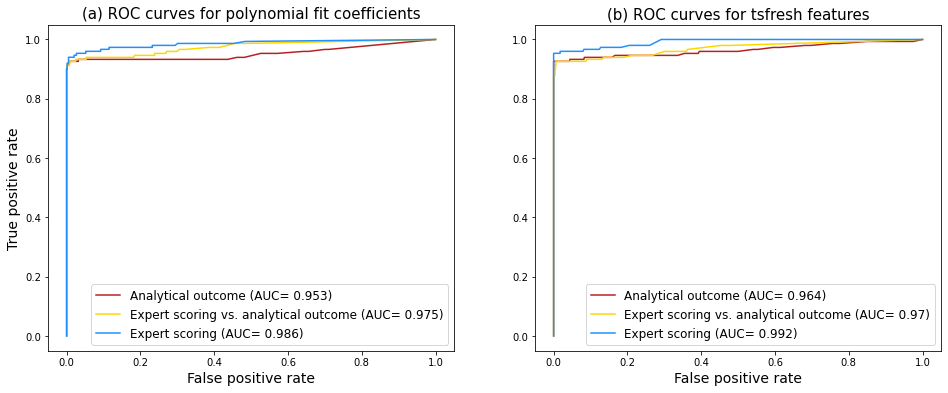

In [25]:
# ROC curves PolyFit
colors = {'Analytical outcome': 'firebrick', 'Expert scoring vs. analytical outcome': 'gold',
       'Expert scoring': 'dodgerblue'}
combos = [(new_grouped_scores_analytic, new_labels_analytic, 'Analytical outcome'), 
          (new_grouped_scores_overruled, new_labels_analytic, 'Expert scoring vs. analytical outcome'), 
          (new_grouped_scores_overruled, new_labels, 'Expert scoring')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
for combo in combos:
    scores, labs, col = combo[0], combo[1], combo[2]
    probs = scores['RF_PolyFitCoefs']
    fpr, tpr, thresholds = roc_curve(labs, probs)
    AUC = round(auc(fpr, tpr), 3)
    ax1.plot(fpr, tpr, label=col+' (AUC= '+str(AUC)+')', color=colors[col])
for combo in combos:
    scores, labs, col = combo[0], combo[1], combo[2]
    probs = scores['RF_TSfresh']
    fpr, tpr, thresholds = roc_curve(labs, probs)
    AUC = round(auc(fpr, tpr), 3)
    ax2.plot(fpr, tpr, label=col+' (AUC= '+str(AUC)+')', color=colors[col])   
ax1.legend(prop={'size': 12}), ax2.legend(prop={'size': 12})
ax1.set_xlabel('False positive rate', fontsize=14)
ax2.set_xlabel('False positive rate', fontsize=14)
ax1.set_ylabel('True positive rate', fontsize=14)
ax1.set_title('(a) ROC curves for polynomial fit coefficients', fontsize=15)
ax2.set_title('(b) ROC curves for tsfresh features', fontsize=15)
fig.savefig('/Users/dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/grouped_nestedCV_ROC.png', dpi=400)

In [26]:
best_combo = 'RF_PolyFitCoefs'
probs = new_grouped_scores_overruled[best_combo]
fpr, tpr, thresholds = roc_curve(new_labels_analytic, probs) # OVERRULED VS ANALYTIC!
pd.DataFrame({'Specificity': 1-fpr, 'Sensitivity': tpr, 'threshold': thresholds}).iloc[10:60,:]

,Specificity,Sensitivity,threshold
10,0.992434,0.919463,0.429333
11,0.991173,0.919463,0.404667
12,0.991173,0.926174,0.339000
13,0.976040,0.926174,0.152000
14,0.976040,0.932886,0.150000
15,0.962169,0.932886,0.095500
16,0.958386,0.932886,0.088000
17,0.947037,0.932886,0.064000
18,0.947037,0.939597,0.063333
19,0.940731,0.939597,0.058000


In [9]:
expert_sens = 0.946
expert_spec = 0.985
optimal_threshold = ((0.939597-0.936948)/(0.940731-0.936948))*(0.058-0.056)+0.056 # sens = spec = 94.0%
equal_sens = 0.011000 # corresponding spec = 81.6%
equal_spec = ((expert_spec-0.976040)/(0.991173-0.976040))*(0.339-0.152)+0.152 # corresponding sens = 92.6%
print('optimal threshold: ', optimal_threshold)
print('equal sensitivity: ', equal_sens)
print('equal specificity: ', equal_spec)

optimal threshold:  0.05740047581284696
equal sensitivity:  0.011
equal specificity:  0.2627196193748761


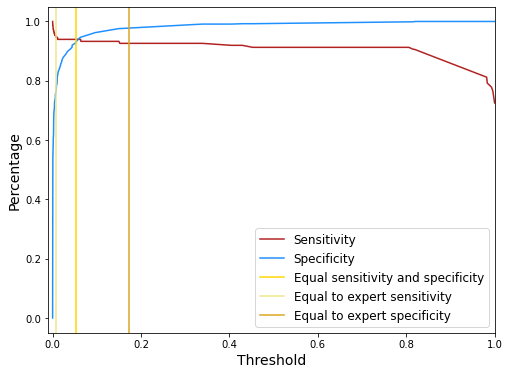

In [27]:
# sensitivity & specificity plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, tpr, label='Sensitivity', c='firebrick')
ax.plot(thresholds, 1-fpr, label='Specificity', c='dodgerblue')
#ax.set_title('Sensitivity & specificity of polynomial fit coefficients')
ax.set_xlabel('Threshold', size=14)
ax.set_ylabel('Percentage', size=14)
ax.axvline(x=optimal_threshold, c='gold', label='Equal sensitivity and specificity')
ax.axvline(x=equal_sens, c='khaki', label='Equal to expert sensitivity')
ax.axvline(x=equal_spec, c='goldenrod', label='Equal to expert specificity')
ax.legend(prop={'size': 12})
ax.set_xlim(-0.01,1)
fig.savefig('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/grouped_nestedCV_ExpertVSAnalytic_SSplot.png', dpi=400)

#### Stratified Shuffle split

In [14]:
# compute performance metrics (don't run twice -> weights & labels of empty samples are deleted here)
shuffled_scores_analytic = pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/shuffled_nestedCV_analytic.csv')
shuffled_scores_overruled = pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/shuffled_nestedCV_overruled.csv')
#shuffled_metrics_analytic = {'Classifier + Featureset': [], 'AUC': [], 'F measure':[], 'Recall': [], 'Precision': []}
#shuffled_metrics_overruled = {'Classifier + Featureset': [], 'AUC': [], 'F measure':[], 'Recall': [], 'Precision': []}
#shuffled_metrics_anaover = {'Classifier + Featureset': [], 'AUC': [], 'F measure':[], 'Recall': [], 'Precision': []}

to_delete = []
for i in range(len(weights)):
    # delete the empty samples (weight == 0)
    if weights[i] == 0:
        to_delete.append(i)
        
    # delete the positive controls
    if labels_meaning[i] == 'pos':
        to_delete.append(i)
        
print('check?', len(list(set(to_delete))) == len(to_delete)) # test

shuffled_scores_analytic = shuffled_scores_analytic.drop(to_delete, axis=0)
shuffled_scores_analytic = shuffled_scores_analytic.reset_index(drop=True)
shuffled_scores_overruled = shuffled_scores_overruled.drop(to_delete, axis=0)
shuffled_scores_overruled = shuffled_scores_overruled.reset_index(drop=True)
labels = [lab for i, lab in enumerate(labels) if i not in to_delete]
labels_analytic = [lab for i, lab in enumerate(labels_analytic) if i not in to_delete]
weights = [w for i, w in enumerate(weights) if i not in to_delete]

check? True


In [15]:
# make final prediction scores (average the duplicate samples)
new_labels = []; new_labels_analytic = []
polyfit_analytic = []; polyfit_overruled = []
tsfresh_analytic = []; tsfresh_overruled = []
new_shuffled_scores_analytic = {}; new_shuffled_scores_overruled = {}

for i in range(0, len(labels), 2):
    # append 'new' labels
    new_labels.append(labels[i])
    new_labels_analytic.append(labels_analytic[i])
    
    # take average predictions
    polyfit_analytic.append((shuffled_scores_analytic['RF_PolyFitCoefs'][i] + shuffled_scores_analytic['RF_PolyFitCoefs'][i+1])/2)
    tsfresh_analytic.append((shuffled_scores_analytic['RF_TSfresh'][i] + shuffled_scores_analytic['RF_TSfresh'][i+1])/2)
    polyfit_overruled.append((shuffled_scores_overruled['RF_PolyFitCoefs'][i] + shuffled_scores_overruled['RF_PolyFitCoefs'][i+1])/2)
    tsfresh_overruled.append((shuffled_scores_overruled['RF_TSfresh'][i] + shuffled_scores_overruled['RF_TSfresh'][i+1])/2)
print('check?', i == 1882)

new_shuffled_scores_analytic = pd.DataFrame({'RF_PolyFitCoefs': polyfit_analytic, 'RF_TSfresh': tsfresh_analytic})
new_shuffled_scores_overruled = pd.DataFrame({'RF_PolyFitCoefs': polyfit_overruled, 'RF_TSfresh': tsfresh_overruled})

check? True


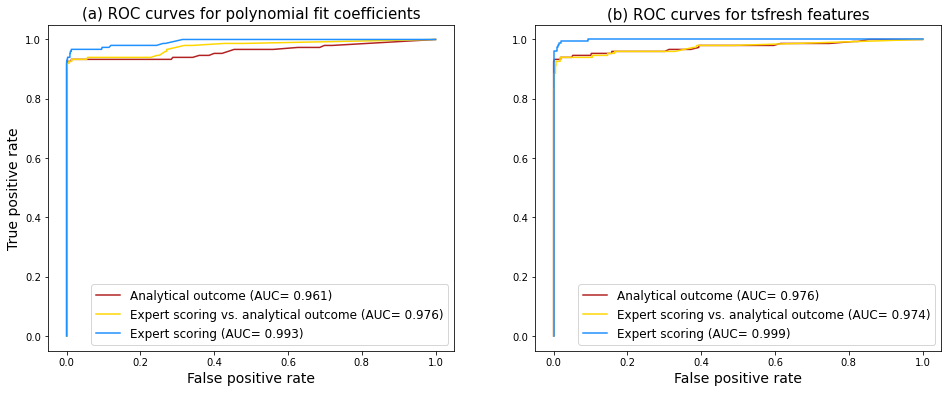

In [16]:
# ROC curves PolyFit
colors = {'Analytical outcome': 'firebrick', 'Expert scoring vs. analytical outcome': 'gold',
       'Expert scoring': 'dodgerblue'}
combos = [(new_shuffled_scores_analytic, new_labels_analytic, 'Analytical outcome'), 
          (new_shuffled_scores_overruled, new_labels_analytic, 'Expert scoring vs. analytical outcome'), 
          (new_shuffled_scores_overruled, new_labels, 'Expert scoring')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
for combo in combos:
    scores, labs, col = combo[0], combo[1], combo[2]
    probs = scores['RF_PolyFitCoefs']
    fpr, tpr, thresholds = roc_curve(labs, probs)
    AUC = round(auc(fpr, tpr), 3)
    ax1.plot(fpr, tpr, label=col+' (AUC= '+str(AUC)+')', color=colors[col])
for combo in combos:
    scores, labs, col = combo[0], combo[1], combo[2]
    probs = scores['RF_TSfresh']
    fpr, tpr, thresholds = roc_curve(labs, probs)
    AUC = round(auc(fpr, tpr), 3)
    ax2.plot(fpr, tpr, label=col+' (AUC= '+str(AUC)+')', color=colors[col])
ax1.legend(prop={'size': 12}), ax2.legend(prop={'size': 12})
ax1.set_xlabel('False positive rate', fontsize=14)
ax2.set_xlabel('False positive rate', fontsize=14)
ax1.set_ylabel('True positive rate', fontsize=14)
ax1.set_title('(a) ROC curves for polynomial fit coefficients', fontsize=15)
ax2.set_title('(b) ROC curves for tsfresh features', fontsize=15)    
fig.savefig('/Users/dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/shuffled_nestedCV_ROC.png', dpi=400)

In [18]:
best_combo = 'RF_PolyFitCoefs'
probs = new_shuffled_scores_overruled[best_combo]
fpr, tpr, thresholds = roc_curve(new_labels_analytic, probs) # OVERRULED VS ANALYTIC!
pd.DataFrame({'Specificity': 1-fpr, 'Sensitivity': tpr, 'Threshold': thresholds}).iloc[20:70,:]

,Specificity,Sensitivity,Threshold
20,0.960908,0.932886,0.077000
21,0.955864,0.932886,0.062000
22,0.952081,0.932886,0.058667
23,0.949559,0.932886,0.058000
24,0.945776,0.932886,0.054000
25,0.943253,0.939597,0.054000
26,0.941992,0.939597,0.053000
27,0.939470,0.939597,0.052000
28,0.936948,0.939597,0.051000
29,0.934426,0.939597,0.050000


In [19]:
expert_sens = 0.946
expert_spec = 0.985
optimal_threshold = ((0.939597-0.939470)/(0.941992-0.939470))*(0.053-0.052)+0.052 # sens = spec = 94.0%
equal_sens = 0.008 # corresponding spec = 75.5%
equal_spec = ((expert_spec-0.968474)/(0.986129-0.968474))*(0.178-0.09)+0.09 # corresponding sens = 93.3%
print('optimal threshold: ', optimal_threshold)
print('equal sensitivity: ', equal_sens)
print('equal specificity: ', equal_spec)

optimal threshold:  0.0520503568596352
equal sensitivity:  0.008
equal specificity:  0.1723725856697817


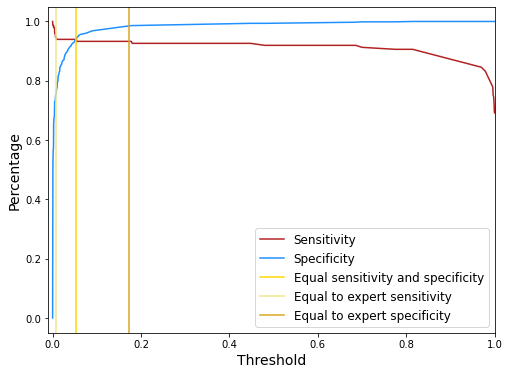

In [21]:
# sensitivity & specificity plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, tpr, label='Sensitivity', c='firebrick')
ax.plot(thresholds, 1-fpr, label='Specificity', c='dodgerblue')
#ax.set_title('Sensitivity & specificity of polynomial fit coefficients')
ax.set_xlabel('Threshold', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.axvline(x=optimal_threshold, c='gold', label='Equal sensitivity and specificity')
ax.axvline(x=equal_sens, c='khaki', label='Equal to expert sensitivity')
ax.axvline(x=equal_spec, c='goldenrod', label='Equal to expert specificity')
ax.set_xlim(-0.01,1)
ax.legend(prop={'size': 12})
fig.savefig('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/shuffled_nestedCV_ExpertVSAnalytic_SSplot.png', dpi=400)

## 4 - Venn diagram

In [42]:
# process predictions (don't run twice -> weights & labels of empty samples are deleted here)
grouped_scores_overruled = pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/grouped_nestedCV_overruled.csv')

to_delete = []
for i in range(len(weights)):
    if weights[i] == 0:
        to_delete.append(i)
    # delete the positive controls
    if labels_meaning[i] == 'pos':
        to_delete.append(i)    
print('check?', len(list(set(to_delete))) == len(to_delete)) # test
        
grouped_scores_overruled = grouped_scores_overruled.drop(to_delete, axis=0)
grouped_scores_overruled = grouped_scores_overruled.reset_index(drop=True)
labels_analytic = [lab for i, lab in enumerate(labels_analytic) if i not in to_delete]
labels_test = [lab for i, lab in enumerate(labels_test) if i not in to_delete]
weights = [w for i, w in enumerate(weights) if i not in to_delete]

# make final prediction scores (average the duplicate samples)
new_labels_test = []; new_labels_analytic = []
polyfit_overruled = []; tsfresh_overruled = []
new_grouped_scores_overruled = {}

for i in range(0, len(labels_test), 2):
    # append 'new' labels
    new_labels_test.append(labels_test[i])
    new_labels_analytic.append(labels_analytic[i])
    
    # take average predictions
    polyfit_overruled.append((grouped_scores_overruled['RF_PolyFitCoefs'][i] + grouped_scores_overruled['RF_PolyFitCoefs'][i+1])/2)
    tsfresh_overruled.append((grouped_scores_overruled['RF_TSfresh'][i] + grouped_scores_overruled['RF_TSfresh'][i+1])/2)
print('check?', i == 1882)

new_grouped_scores_overruled = pd.DataFrame({'RF_PolyFitCoefs': polyfit_overruled, 'RF_TSfresh': tsfresh_overruled})
probs = new_grouped_scores_overruled['RF_PolyFitCoefs']

check? True
check? True


In [45]:
# compute the positive venn diagram components
venn_1 = 0; venn_2 = 0; venn_3 = 0; venn_4 = 0; venn_5 = 0; venn_6 = 0; venn_7 = 0
for i in range(len(new_labels_test)):
    ml_pred = (probs[i] > 0.057)*1
    
    if (new_labels_analytic[i]) == 1 and (new_labels_test[i] == 0) and (ml_pred == 0): # outcomes missed by expert and ML
        venn_1 += 1
    elif (new_labels_analytic[i]) == 0 and (new_labels_test[i] == 1) and (ml_pred == 0): # false positives expert
        venn_2 += 1
    elif (new_labels_analytic[i]) == 1 and (new_labels_test[i] == 1) and (ml_pred == 0): # outcomes missed by ML
        venn_3 += 1
    elif (new_labels_analytic[i]) == 0 and (new_labels_test[i] == 0) and (ml_pred == 1): # false positives ML
        venn_4 += 1
    elif (new_labels_analytic[i]) == 1 and (new_labels_test[i] == 0) and (ml_pred == 1): # outcomes missed by expert
        venn_5 += 1
    elif (new_labels_analytic[i]) == 0 and (new_labels_test[i] == 1) and (ml_pred == 1): # false positives both expert and ML
        venn_6 += 1
    elif (new_labels_analytic[i]) == 1 and (new_labels_test[i] == 1) and (ml_pred == 1): # correct by expert and ML
        venn_7 += 1

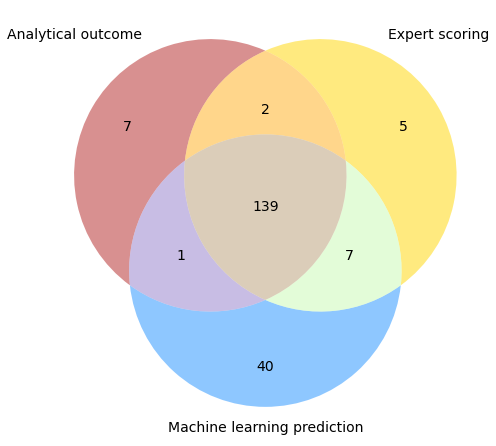

In [47]:
colors = ('firebrick', 'gold', 'dodgerblue')
fig, ax = plt.subplots(figsize=(8,8))
vd = venn3_unweighted(subsets=(venn_1, venn_2, venn_3, venn_4, venn_5, venn_6, venn_7),
                 set_labels=('Analytical outcome', 'Expert scoring', 'Machine learning prediction'), 
                 alpha=0.5, ax=ax, set_colors=('firebrick', 'gold', 'dodgerblue'))

for text in vd.subset_labels:
    text.set_fontsize(14)
for text in vd.set_labels:
    text.set_fontsize(14)
fig.savefig('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/venn_positives.png', dpi=400)

## 5 - AUC confidence intervals

In [35]:
# process predictions (don't run twice -> weights & labels of empty samples are deleted here)
grouped_scores_analytic = pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/grouped_nestedCV_analytic.csv')
grouped_scores_overruled = pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/grouped_nestedCV_overruled.csv')
shuffled_scores_analytic = pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/shuffled_nestedCV_analytic.csv')
shuffled_scores_overruled = pd.read_csv('/Users/Dimi/Documents/GitHub_Local/SYNTH_DRUG_DETECTION/results/shuffled_nestedCV_overruled.csv')

to_delete = []
for i in range(len(weights)):
    # delete the empty samples (weight == 0)
    if weights[i] == 0:
        to_delete.append(i)
        
    # delete the positive controls
    if labels_meaning[i] == 'pos':
        to_delete.append(i)
        
print('check?', len(list(set(to_delete))) == len(to_delete)) # test
    
grouped_scores_analytic = grouped_scores_analytic.drop(to_delete, axis=0)
grouped_scores_analytic = grouped_scores_analytic.reset_index(drop=True)
grouped_scores_overruled = grouped_scores_overruled.drop(to_delete, axis=0)
grouped_scores_overruled = grouped_scores_overruled.reset_index(drop=True)

shuffled_scores_analytic = shuffled_scores_analytic.drop(to_delete, axis=0)
shuffled_scores_analytic = shuffled_scores_analytic.reset_index(drop=True)
shuffled_scores_overruled = shuffled_scores_overruled.drop(to_delete, axis=0)
shuffled_scores_overruled = shuffled_scores_overruled.reset_index(drop=True)

labels = [lab for i, lab in enumerate(labels) if i not in to_delete]
labels_analytic = [lab for i, lab in enumerate(labels_analytic) if i not in to_delete]
weights = [w for i, w in enumerate(weights) if i not in to_delete]

check? True


In [36]:
# make final prediction scores (average the duplicate samples)
new_labels = []; new_labels_analytic = []
polyfit_analytic_gr = []; polyfit_overruled_gr = []
tsfresh_analytic_gr = []; tsfresh_overruled_gr = []
polyfit_analytic_sh = []; polyfit_overruled_sh = []
tsfresh_analytic_sh = []; tsfresh_overruled_sh = []
new_grouped_scores_analytic = {}; new_grouped_scores_overruled = {}
new_shuffled_scores_analytic = {}; new_shuffled_scores_overruled = {}

for i in range(0, len(labels), 2):
    # append 'new' labels
    new_labels.append(labels[i])
    new_labels_analytic.append(labels_analytic[i])
    
    # take average predictions (GROUPED)
    polyfit_analytic_gr.append((grouped_scores_analytic['RF_PolyFitCoefs'][i] + grouped_scores_analytic['RF_PolyFitCoefs'][i+1])/2)
    tsfresh_analytic_gr.append((grouped_scores_analytic['RF_TSfresh'][i] + grouped_scores_analytic['RF_TSfresh'][i+1])/2)
    polyfit_overruled_gr.append((grouped_scores_overruled['RF_PolyFitCoefs'][i] + grouped_scores_overruled['RF_PolyFitCoefs'][i+1])/2)
    tsfresh_overruled_gr.append((grouped_scores_overruled['RF_TSfresh'][i] + grouped_scores_overruled['RF_TSfresh'][i+1])/2)
    
    # take average predictions (SHUFFLED)
    polyfit_analytic_sh.append((shuffled_scores_analytic['RF_PolyFitCoefs'][i] + shuffled_scores_analytic['RF_PolyFitCoefs'][i+1])/2)
    tsfresh_analytic_sh.append((shuffled_scores_analytic['RF_TSfresh'][i] + shuffled_scores_analytic['RF_TSfresh'][i+1])/2)
    polyfit_overruled_sh.append((shuffled_scores_overruled['RF_PolyFitCoefs'][i] + shuffled_scores_overruled['RF_PolyFitCoefs'][i+1])/2)
    tsfresh_overruled_sh.append((shuffled_scores_overruled['RF_TSfresh'][i] + shuffled_scores_overruled['RF_TSfresh'][i+1])/2)
print('check?', i == 1882)

new_grouped_scores_analytic = pd.DataFrame({'RF_PolyFitCoefs': polyfit_analytic_gr, 'RF_TSfresh': tsfresh_analytic_gr})
new_grouped_scores_overruled = pd.DataFrame({'RF_PolyFitCoefs': polyfit_overruled_gr, 'RF_TSfresh': tsfresh_overruled_gr})
new_shuffled_scores_analytic = pd.DataFrame({'RF_PolyFitCoefs': polyfit_analytic_sh, 'RF_TSfresh': tsfresh_analytic_sh})
new_shuffled_scores_overruled = pd.DataFrame({'RF_PolyFitCoefs': polyfit_overruled_sh, 'RF_TSfresh': tsfresh_overruled_sh})

check? True


In [37]:
# RUN THE BOOTSTRAP (GROUPED - POLYFIT)
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)
combos = [(new_grouped_scores_analytic, new_labels_analytic, 'Analytical outcome'),
          (new_grouped_scores_overruled, new_labels_analytic, 'Expert scoring vs. analytical outcome'), 
          (new_grouped_scores_overruled, new_labels, 'Expert scoring')]

for combo in combos:
    bootstrapped_scores = []
    scores, labs, col = combo[0], np.asarray(combo[1]), combo[2]
    probs = scores['RF_PolyFitCoefs']
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(probs), len(probs))
        if len(np.unique(labs[indices])) < 2:
            continue # Need at least one positive, one negative sample for ROC AUC: reject sample

        fpr, tpr, thresholds = roc_curve(labs[indices], probs[indices])
        AUC = round(auc(fpr, tpr), 3)
        bootstrapped_scores.append(AUC)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, AUC))

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    conf_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    conf_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    print("Confidence interval for the ", col, ": [{:0.3f} - {:0.3}]".format(conf_lower, conf_upper))

Confidence interval for the  Analytical outcome : [0.920 - 0.979]
Confidence interval for the  Expert scoring vs. analytical outcome : [0.955 - 0.99]
Confidence interval for the  Expert scoring : [0.972 - 0.997]


In [38]:
# RUN THE BOOTSTRAP (GROUPED - TSFRESH)
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)
combos = [(new_grouped_scores_analytic, new_labels_analytic, 'Analytical outcome'),
          (new_grouped_scores_overruled, new_labels_analytic, 'Expert scoring vs. analytical outcome'), 
          (new_grouped_scores_overruled, new_labels, 'Expert scoring')]

for combo in combos:
    bootstrapped_scores = []
    scores, labs, col = combo[0], np.asarray(combo[1]), combo[2]
    probs = scores['RF_TSfresh']
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(probs), len(probs))
        if len(np.unique(labs[indices])) < 2:
            continue # Need at least one positive, one negative sample for ROC AUC: reject sample

        fpr, tpr, thresholds = roc_curve(labs[indices], probs[indices])
        AUC = round(auc(fpr, tpr), 3)
        bootstrapped_scores.append(AUC)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, AUC))

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    conf_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    conf_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    print("Confidence interval for the ", col, ": [{:0.3f} - {:0.3}]".format(conf_lower, conf_upper))

Confidence interval for the  Analytical outcome : [0.938 - 0.986]
Confidence interval for the  Expert scoring vs. analytical outcome : [0.948 - 0.989]
Confidence interval for the  Expert scoring : [0.984 - 0.998]


In [39]:
# RUN THE BOOTSTRAP (SHUFFLED - POLYFIT)
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)
combos = [(new_shuffled_scores_analytic, new_labels_analytic, 'Analytical outcome'),
          (new_shuffled_scores_overruled, new_labels_analytic, 'Expert scoring vs. analytical outcome'), 
          (new_shuffled_scores_overruled, new_labels, 'Expert scoring')]

for combo in combos:
    bootstrapped_scores = []
    scores, labs, col = combo[0], np.asarray(combo[1]), combo[2]
    probs = scores['RF_PolyFitCoefs']
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(probs), len(probs))
        if len(np.unique(labs[indices])) < 2:
            continue # Need at least one positive, one negative sample for ROC AUC: reject sample

        fpr, tpr, thresholds = roc_curve(labs[indices], probs[indices])
        AUC = round(auc(fpr, tpr), 3)
        bootstrapped_scores.append(AUC)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, AUC))

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    conf_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    conf_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    print("Confidence interval for the ", col, ": [{:0.3f} - {:0.3}]".format(conf_lower, conf_upper))

Confidence interval for the  Analytical outcome : [0.934 - 0.984]
Confidence interval for the  Expert scoring vs. analytical outcome : [0.958 - 0.992]
Confidence interval for the  Expert scoring : [0.985 - 0.999]


In [40]:
# RUN THE BOOTSTRAP (SHUFFLED - TSFRESH)
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)
combos = [(new_shuffled_scores_analytic, new_labels_analytic, 'Analytical outcome'),
          (new_shuffled_scores_overruled, new_labels_analytic, 'Expert scoring vs. analytical outcome'), 
          (new_shuffled_scores_overruled, new_labels, 'Expert scoring')]

for combo in combos:
    bootstrapped_scores = []
    scores, labs, col = combo[0], np.asarray(combo[1]), combo[2]
    probs = scores['RF_TSfresh']
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(probs), len(probs))
        if len(np.unique(labs[indices])) < 2:
            continue # Need at least one positive, one negative sample for ROC AUC: reject sample

        fpr, tpr, thresholds = roc_curve(labs[indices], probs[indices])
        AUC = round(auc(fpr, tpr), 3)
        bootstrapped_scores.append(AUC)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, AUC))

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    conf_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    conf_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    print("Confidence interval for the ", col, ": [{:0.3f} - {:0.3}]".format(conf_lower, conf_upper))

Confidence interval for the  Analytical outcome : [0.954 - 0.992]
Confidence interval for the  Expert scoring vs. analytical outcome : [0.953 - 0.992]
Confidence interval for the  Expert scoring : [0.997 - 1.0]


## 6 - Legacy / out-of-use